## 安装环境

In [1]:
# Requirements
!pip install transformers
!pip install openai
!pip install openTSNE
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 100.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 129.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 300.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 20.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 25

## 从骆驼嵌入项目中获取数据

In [2]:
!git clone https://github.com/LC1332/Luotuo-Text-Embedding.git

Cloning into 'Luotuo-Text-Embedding'...
remote: Enumerating objects: 622, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 622 (delta 7), reused 13 (delta 5), pack-reused 602
Receiving objects: 100% (622/622), 36.68 MiB | 11.43 MiB/s, done.
Resolving deltas: 100% (372/372), done.


## 从Hugging Face中获取模型

我们的骆驼BERT的主要模型为luotuo-bert

现在暂时是110M的小模型。之后中模型上线之后,luotuo-bert会替换为300M以上的较大的模型，同时小模型会更名为luotuo-bert-small

In [3]:
import torch
from scipy.spatial.distance import cosine
from transformers import AutoModel, AutoTokenizer
from argparse import Namespace
# Import our models. The package will take care of downloading the models automatically
tokenizer = AutoTokenizer.from_pretrained("silk-road/luotuo-bert")
model_args = Namespace(do_mlm=None, pooler_type="cls", temp=0.05, mlp_only_train=False, init_embeddings_model=None)
model = AutoModel.from_pretrained("silk-road/luotuo-bert", trust_remote_code=True, model_args=model_args)

A new version of the following files was downloaded from https://huggingface.co/silk-road/luotuo-bert:
- models.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


## 创建 data 目录存储文本数据集

In [4]:
import os
import shutil
import gdown
import zipfile

directory = './data'

if os.path.exists(directory):
    shutil.rmtree(directory)
os.mkdir(directory)

url = 'https://drive.google.com/uc?id=1V2Usl_sTg_nN6bwR835eFAvhgk4x2S9a'
output = './data/posts.zip'

gdown.download(url, output, quiet=False)

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall(directory)

os.remove(output)

!rm -r ./data/__MACOSX

Downloading...
From: https://drive.google.com/uc?id=1V2Usl_sTg_nN6bwR835eFAvhgk4x2S9a
To: /content/data/posts.zip
100%|██████████| 10.0M/10.0M [00:00<00:00, 131MB/s]


## t-SNE 文本可视化实验

In [5]:
%cd Luotuo-Text-Embedding

/content/Luotuo-Text-Embedding


In [6]:
import pandas as pd

tsne_data_label_path_neg = "/content/data/posts/neg_posts_twitter.csv"
tsne_data_label_path_pos = "/content/data/posts/pos_posts_weibo.csv"

neg_data = pd.read_csv(tsne_data_label_path_neg, header=0)
pos_data = pd.read_csv(tsne_data_label_path_pos, header=0)

text_left = neg_data["Content"].tolist()[:300]
text_right = pos_data['content'].tolist()[:300]
neg_label = neg_data["label"].tolist()[:300]
pos_label = pos_data["label"].tolist()[:300]

In [7]:
import csv
import numpy as np
import sys
sys.path.append("..")


inputs = tokenizer(text_left, padding=True, truncation=True, max_length=512, return_tensors="pt")
with torch.no_grad():
    embeddings_left = model(**inputs, output_hidden_states=True, return_dict=True, sent_emb=True).pooler_output
inputs = tokenizer(text_right, padding=True, truncation=True, max_length=512, return_tensors="pt")
with torch.no_grad():
    embeddings_right = model(**inputs, output_hidden_states=True, return_dict=True, sent_emb=True).pooler_output
    
cos_sim_matrix = torch.matmul(embeddings_left, embeddings_right.t())
cos_sim_matrix /= torch.matmul(torch.norm(embeddings_left, dim=1, keepdim=True), torch.norm(embeddings_right, dim=1, keepdim=True).t())
tensor_cpu = cos_sim_matrix.cpu()

## 绘制tSNE可视化

In [8]:
import sys
sys.path.append("..")
from lib.tsne import TSNE_Plot

merged_list = text_left + text_right
label = [0]*len(text_left) + [1]*len(text_right)
merged_embed = torch.cat((embeddings_left, embeddings_right), dim=0)

tsne_plot = TSNE_Plot(merged_list, merged_embed, label=label)
tsne_plot.tsne_plot(n_sentence=40)

In [9]:
import torch
from torch import nn
import torch.optim as optim
from transformers import AutoModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("silk-road/luotuo-bert")
model_args = Namespace(do_mlm=None, pooler_type="cls", temp=0.05, mlp_only_train=False, init_embeddings_model=None)
model = AutoModel.from_pretrained("silk-road/luotuo-bert", trust_remote_code=True, model_args=model_args)

# Define the classifier
class Classifier(nn.Module):
    def __init__(self, bert_model, hidden_size=1536, num_classes=2):
        super(Classifier, self).__init__()
        self.bert_model = bert_model
        self.linear1 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, num_classes)

    def forward(self, **inputs):
        outputs = self.bert_model(output_hidden_states=True, return_dict=True, sent_emb=True, **inputs)
        pooled_output = outputs[1]
        x = self.linear1(pooled_output)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# Freeze the parameters of the BERT model
for param in model.parameters():
    param.requires_grad = False

# Initialize the classifier using the BERT model
classifier = Classifier(model)

# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(classifier.parameters())

## 准备数据

In [15]:
from sklearn.model_selection import train_test_split

data_neg = "/content/data/posts/neg_posts_twitter.csv"
data_pos = "/content/data/posts/pos_posts_weibo.csv"

data_neg = pd.read_csv(data_neg, header=0)
data_pos = pd.read_csv(data_pos, header=0)

content_neg = data_neg["Content"].tolist()[:10000]
content_pos = data_pos['content'].tolist()[:10000]
label_neg = data_neg["label"].tolist()[:10000]
label_pos = data_pos["label"].tolist()[:10000]

text = content_neg + content_pos
labels = label_neg + label_pos

# Split the data into training set and test set
train_text, test_text, train_labels, test_labels = train_test_split(text, labels, test_size=0.2, random_state=42)

# Further split the training set into training set and validation set
train_text, val_text, train_labels, val_labels = train_test_split(train_text, train_labels, test_size=0.2, random_state=42)

print("Train set size:", len(train_text))
print("Validation set size:", len(val_text))
print("Test set size:", len(test_text))

train_ratio = len(train_text) / len(text) * 100
val_ratio = len(val_text) / len(text) * 100
test_ratio = len(test_text) / len(text) * 100

print("Train set ratio: {:.2f}%".format(train_ratio))
print("Validation set ratio: {:.2f}%".format(val_ratio))
print("Test set ratio: {:.2f}%".format(test_ratio))

Train set size: 12800
Validation set size: 3200
Test set size: 4000
Train set ratio: 64.00%
Validation set ratio: 16.00%
Test set ratio: 20.00%


In [17]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer

class MyDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(texts, labels, tokenizer, max_len, batch_size):
    dataset = MyDataset(
        texts=texts,
        labels=labels,
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4
    )

BATCH_SIZE = 16
MAX_LEN = 256

# Create DataLoader for training, validation, and test sets
train_data_loader = create_data_loader(train_text, train_labels, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_text, val_labels, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(test_text, test_labels, tokenizer, MAX_LEN, BATCH_SIZE)

In [18]:
from sklearn.metrics import recall_score
from tqdm import tqdm

def train_epoch(model, data_loader, loss_fn, optimizer, device, scaler):
    model = model.train()

    losses = []
    correct_predictions = 0
    recall = []

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["labels"].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        # Count correct predictions
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        # Calculate recall score
        recall.append(recall_score(labels.cpu(), preds.cpu(), average='macro'))

        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    # Calculate accuracy, average loss, and average recall
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    avg_loss = np.mean(losses)
    avg_recall = np.mean(recall)

    return accuracy, avg_loss, avg_recall


In [19]:
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    correct_predictions = 0
    recall = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, labels)

            # Count correct predictions
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            # Calculate recall score
            recall.append(recall_score(labels.cpu(), preds.cpu(), average='macro'))

    # Calculate accuracy, average loss, and average recall
    accuracy = correct_predictions.double() / len(data_loader.dataset)
    avg_loss = np.mean(losses)
    avg_recall = np.mean(recall)

    return accuracy, avg_loss, avg_recall


## 训练

In [20]:
from torch.cuda.amp import GradScaler

EPOCHS = 10
scaler = GradScaler()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classifier = classifier.to(device)

history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': [], 'train_recall': [], 'val_recall': []}

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Train the model
    train_acc, train_loss, train_recall = train_epoch(
        classifier,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scaler
    )

    print(f'Train loss {train_loss} accuracy {train_acc} recall {train_recall}')

    # Evaluate the model on the validation set
    val_acc, val_loss, val_recall = eval_model(
        classifier,
        val_data_loader,
        loss_fn,
        device
    )

    print(f'Val   loss {val_loss} accuracy {val_acc} recall {val_recall}')
    print()

    # Record the metrics in the history dictionary
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['train_recall'].append(train_recall)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    history['val_recall'].append(val_recall)

print("Training complete")


Epoch 1/10
----------


100%|██████████| 800/800 [03:10<00:00,  4.21it/s]

Train loss 0.1282014841309865 accuracy 0.95125 recall 0.9504209367021867


Val   loss 0.09402457998367027 accuracy 0.965 recall 0.9637922424797426

Epoch 2/10
----------


100%|██████████| 800/800 [03:11<00:00,  4.17it/s]

Train loss 0.09657034511328674 accuracy 0.9639062500000001 recall 0.9636211756993006


Val   loss 0.07943776642146987 accuracy 0.9696875 recall 0.9685769647019649

Epoch 3/10
----------


100%|██████████| 800/800 [03:11<00:00,  4.18it/s]

Train loss 0.08231137117662002 accuracy 0.97 recall 0.9697148355117107


Val   loss 0.06584567611396779 accuracy 0.974375 recall 0.9729874639249638

Epoch 4/10
----------


100%|██████████| 800/800 [03:11<00:00,  4.17it/s]

Train loss 0.06699592049597414 accuracy 0.975703125 recall 0.9755443809662561


Val   loss 0.05384324924729299 accuracy 0.980625 recall 0.9797113442113442

Epoch 5/10
----------


100%|██████████| 800/800 [03:11<00:00,  4.18it/s]

Train loss 0.05817687210685108 accuracy 0.97859375 recall 0.9787429220085471


Val   loss 0.04788990441011265 accuracy 0.98375 recall 0.9831069347319348

Epoch 6/10
----------


100%|██████████| 800/800 [03:11<00:00,  4.18it/s]

Train loss 0.04837002285727067 accuracy 0.982265625 recall 0.9821469242562993


Val   loss 0.04531647421303205 accuracy 0.9840625000000001 recall 0.983803515928516

Epoch 7/10
----------


100%|██████████| 800/800 [03:11<00:00,  4.17it/s]

Train loss 0.04352348608931607 accuracy 0.9846875 recall 0.9848062250249751


Val   loss 0.043039091645623556 accuracy 0.9862500000000001 recall 0.9864085220335221

Epoch 8/10
----------


100%|██████████| 800/800 [03:11<00:00,  4.18it/s]

Train loss 0.04022388264512301 accuracy 0.9862500000000001 recall 0.9865248917748918


Val   loss 0.04230639901958057 accuracy 0.9859375 recall 0.9861508283383283

Epoch 9/10
----------


100%|██████████| 800/800 [03:11<00:00,  4.17it/s]

Train loss 0.036278577638477146 accuracy 0.9875 recall 0.9872270403207903


Val   loss 0.04009846380737145 accuracy 0.9868750000000001 recall 0.986906628094128

Epoch 10/10
----------


100%|██████████| 800/800 [03:11<00:00,  4.17it/s]

Train loss 0.029348761059027312 accuracy 0.989453125 recall 0.9894445571789322


Val   loss 0.04242218425137253 accuracy 0.9865625 recall 0.9856961580086581

Training complete


## 可视化训练过程

In [21]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Convert the tensors to lists
    train_acc = [float(x.cpu().numpy()) for x in history['train_acc']]
    val_acc = [float(x.cpu().numpy()) for x in history['val_acc']]
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    train_recall = history['train_recall']
    val_recall = history['val_recall']

    # Create a figure
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(12, 12))

    # Plot training and validation loss
    ax1.plot(train_loss, label='Training Loss', color='blue')
    ax1.scatter(range(len(train_loss)), train_loss, color='blue')
    ax1.plot(val_loss, label='Validation Loss', color='red')
    ax1.scatter(range(len(val_loss)), val_loss, color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot training and validation accuracy
    ax2.plot(train_acc, label='Training Accuracy', color='blue')
    ax2.scatter(range(len(train_acc)), train_acc, color='blue')
    ax2.plot(val_acc, label='Validation Accuracy', color='red')
    ax2.scatter(range(len(val_acc)), val_acc, color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Plot training and validation recall
    ax3.plot(train_recall, label='Training Recall', color='blue')
    ax3.scatter(range(len(train_recall)), train_recall, color='blue')
    ax3.plot(val_recall, label='Validation Recall', color='red')
    ax3.scatter(range(len(val_recall)), val_recall, color='red')
    ax3.set_title('Training and Validation Recall')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Recall')
    ax3.legend()

    # Show the figure
    plt.tight_layout()
    plt.show()

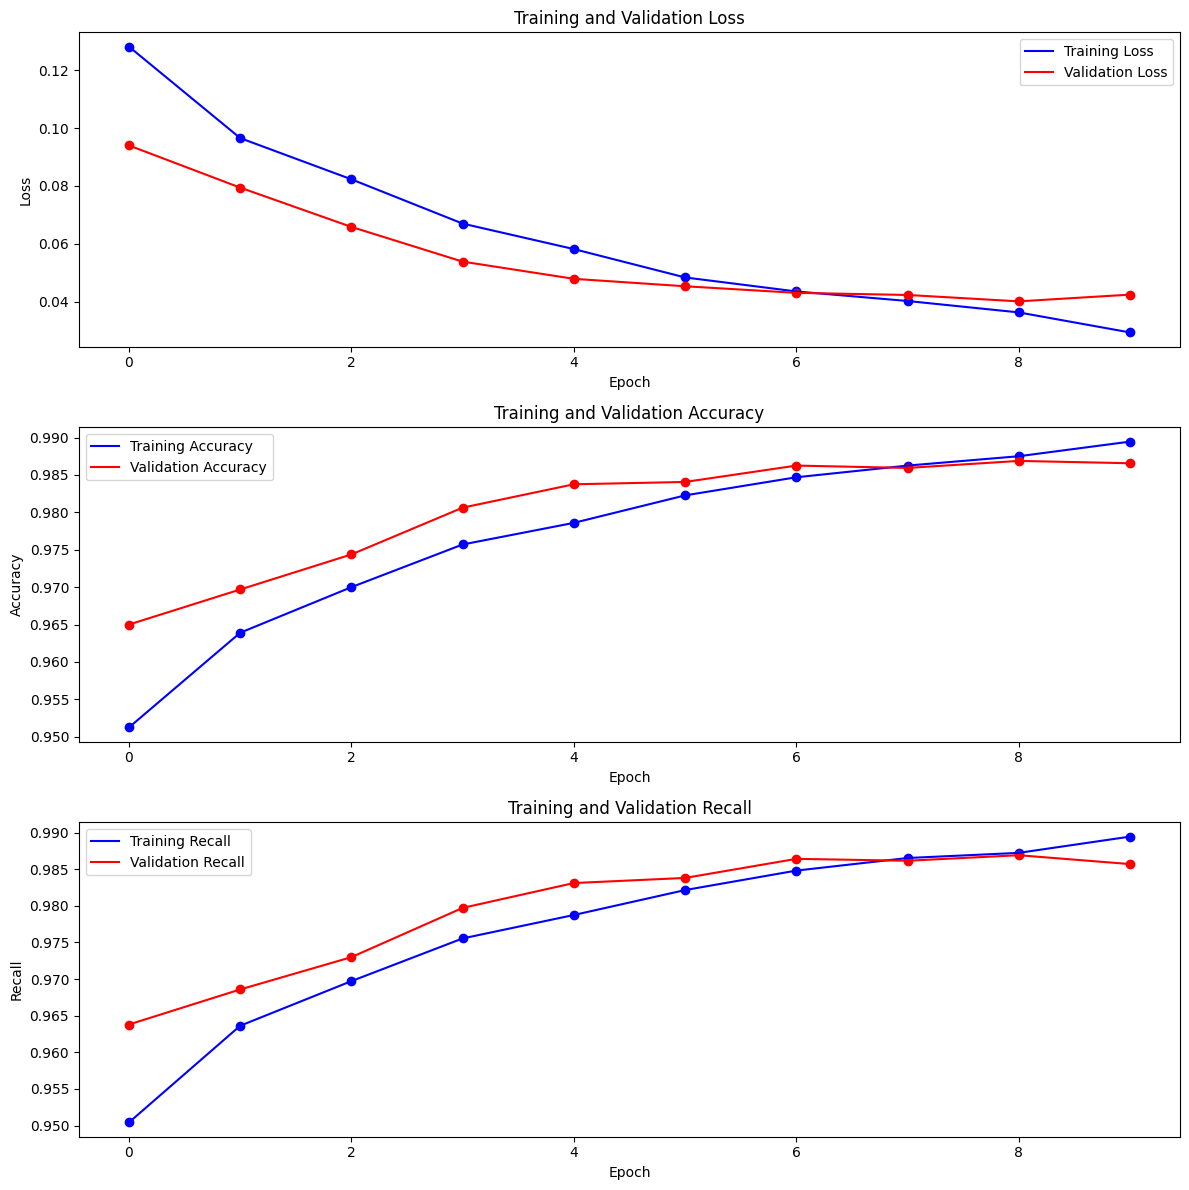

In [22]:
plot_training_history(history)

## 评估模型在测试集上的精确度和召回率

In [23]:
test_acc, _, test_recall = eval_model(
    classifier,
    test_data_loader,
    loss_fn,
    device
)

print(f'Test accuracy: {test_acc.item()}')
print(f'Test recall: {test_recall.item()}')

Test accuracy: 0.98675
Test recall: 0.9851941336441337


In [24]:
label_map = {0: "negative", 1: "positive"}

def predict_text(text, model):
    encoding = tokenizer.encode_plus(
        text,
        max_length=MAX_LEN,
        add_special_tokens=True,
        return_token_type_ids=False,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    _, preds = torch.max(outputs, dim=1)

    # Use the label mapping to convert the predicted label
    pred_label = label_map[preds.item()]

    return pred_label

## Case 测试

In [26]:
text = "胡锡进最近被粉红围攻了，算是被民粹主义反噬了。胡锡进作为民粹主义的头头之一，为中国民粹化也做出突出贡献。不知现在的胡锡进，面对民粹主义狂潮，内心是什么感想？"
pred_label = predict_text(text, classifier)

print("Predicted label:", pred_label)

Predicted label: negative


In [27]:
text = "【官宣！#中国队正式递补东京奥运会接力铜牌#】当地时间19日，国际奥委会正式宣布，中国男子4×100米接力队递补获得东京奥运会铜牌，这是#中国男子4×100米接力首枚奥运奖牌#。由@苏炳添 、@谢震业 、吴智强@_SprinterWu 和汤星强@汤星星丶 组成的中国队共有六种方式获得这枚迟到的奖牌。一旦运动员做出选择，颁奖仪式需要在12个月之内进行（除非选择在下届奥运会领奖）。（刘硕阳、孙龙飞、李洋） 原图"
pred_label = predict_text(text, classifier)

print("Predicted label:", pred_label)

Predicted label: positive
